In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

Load and Explore the Data

In [2]:
# Load the dataset
df = pd.read_csv('advertising.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (200, 4)

First 5 rows:


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [3]:
# Check for missing values and data types
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,15.1305,5.283892,1.6,11.000,16.00,19.050,27.0


Exploratory Data Analysis (EDA)

In [5]:
# Create interactive correlation matrix
corr_matrix = df.corr()
fig = px.imshow(corr_matrix, 
                text_auto=True, 
                aspect="auto",
                title="Correlation Matrix of Advertising Channels and Sales",
                color_continuous_scale='RdBu_r')
fig.show()

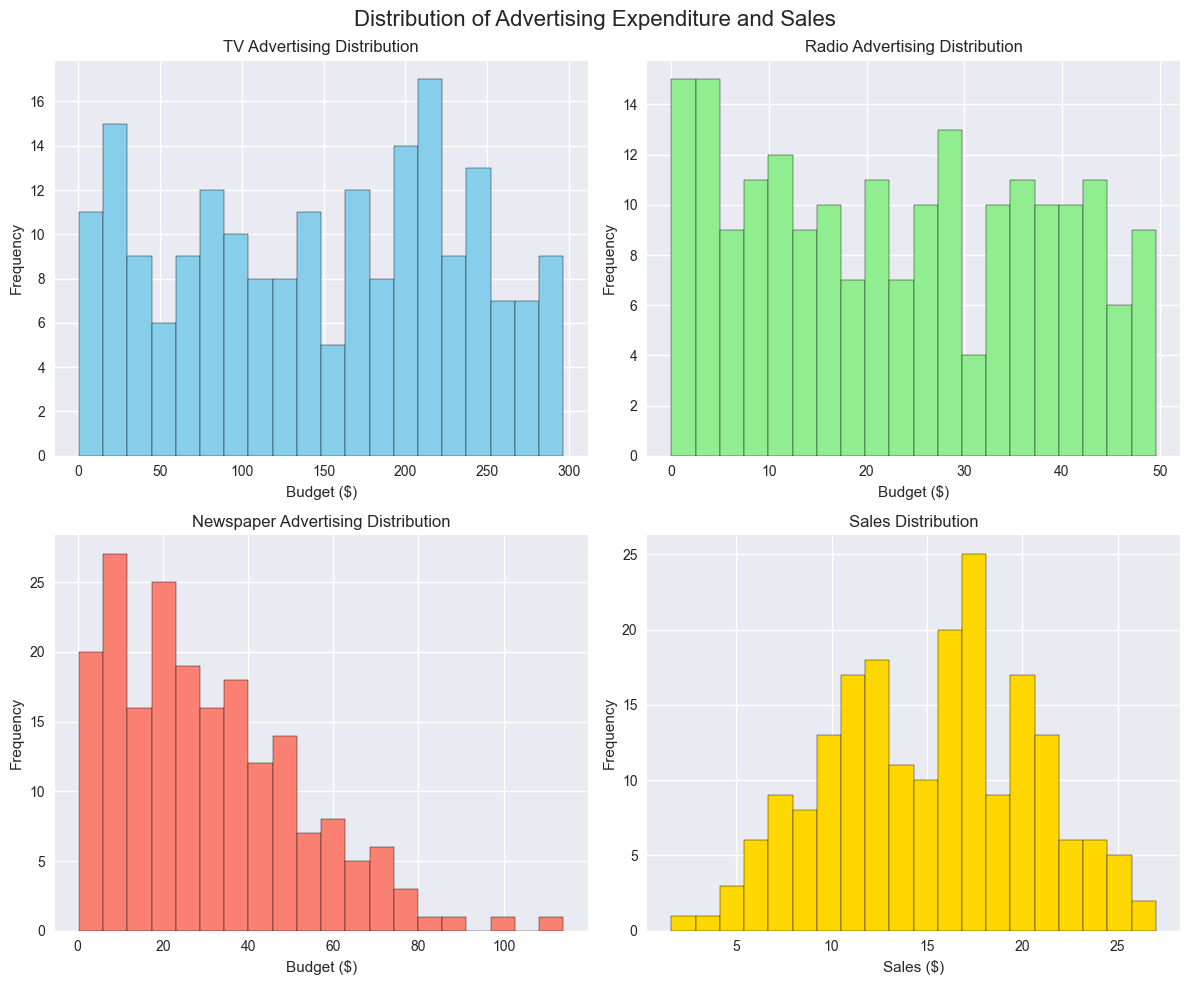

In [6]:
# Distribution of variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of Advertising Expenditure and Sales', fontsize=16)

axes[0,0].hist(df['TV'], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title('TV Advertising Distribution')
axes[0,0].set_xlabel('Budget ($)')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(df['Radio'], bins=20, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Radio Advertising Distribution')
axes[0,1].set_xlabel('Budget ($)')
axes[0,1].set_ylabel('Frequency')

axes[1,0].hist(df['Newspaper'], bins=20, color='salmon', edgecolor='black')
axes[1,0].set_title('Newspaper Advertising Distribution')
axes[1,0].set_xlabel('Budget ($)')
axes[1,0].set_ylabel('Frequency')

axes[1,1].hist(df['Sales'], bins=20, color='gold', edgecolor='black')
axes[1,1].set_title('Sales Distribution')
axes[1,1].set_xlabel('Sales ($)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# Interactive 3D scatter plot
fig = px.scatter_3d(df, x='TV', y='Radio', z='Newspaper', color='Sales',
                    title='3D View of Advertising Channels and Sales',
                    labels={'TV': 'TV Budget', 'Radio': 'Radio Budget', 'Newspaper': 'Newspaper Budget'},
                    opacity=0.7, size_max=10,
                    color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

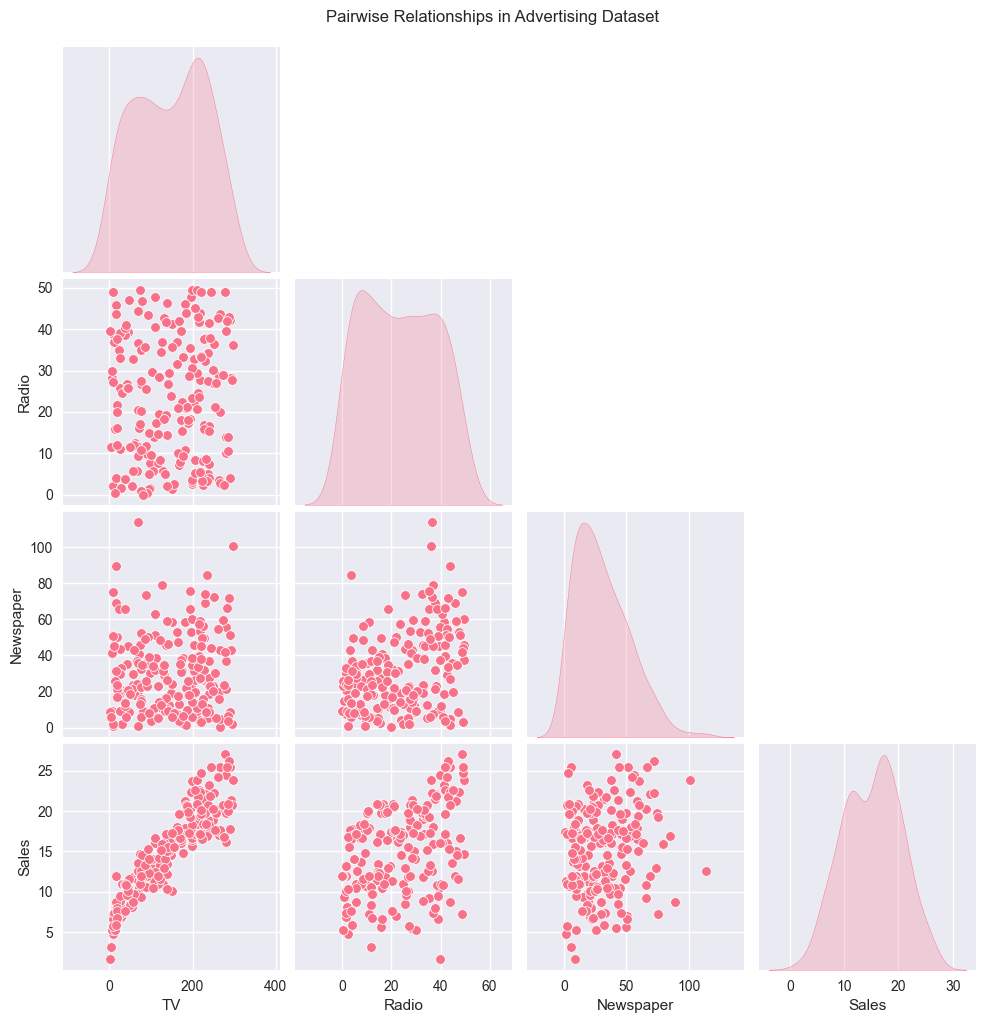

In [8]:
# Pairplot to visualize relationships
sns.pairplot(df, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships in Advertising Dataset', y=1.02)
plt.show()

Feature Engineering

In [9]:
# Create new features
df['Total_Spend'] = df['TV'] + df['Radio'] + df['Newspaper']
df['TV_Radio_Interaction'] = df['TV'] * df['Radio']
df['TV_Newspaper_Interaction'] = df['TV'] * df['Newspaper']
df['Radio_Newspaper_Interaction'] = df['Radio'] * df['Newspaper']
df['Spend_Ratio_TV'] = df['TV'] / df['Total_Spend']
df['Spend_Ratio_Radio'] = df['Radio'] / df['Total_Spend']
df['Spend_Ratio_Newspaper'] = df['Newspaper'] / df['Total_Spend']

# Replace infinite values with 0 (from division by zero)
df = df.replace([np.inf, -np.inf], 0)

# Display new features
df[['Total_Spend', 'TV_Radio_Interaction', 
    'Spend_Ratio_TV', 'Spend_Ratio_Radio', 'Spend_Ratio_Newspaper']].head()

,Total_Spend,TV_Radio_Interaction,Spend_Ratio_TV,Spend_Ratio_Radio,Spend_Ratio_Newspaper
0,337.1,8697.78,0.682587,0.112133,0.205280
1,128.9,1748.85,0.345229,0.304888,0.349884
2,132.4,789.48,0.129909,0.346677,0.523414
3,251.3,6256.95,0.602865,0.164345,0.232789
4,250.0,1952.64,0.723200,0.043200,0.233600


Prepare Data for Modeling

In [10]:
# Define features and target variable
X = df.drop('Sales', axis=1)
y = df['Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (160, 10), (160,)
Test set: (40, 10), (40,)


Model Building and Evaluation

In [11]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Create results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)
results_df

,RMSE,MAE,R2
Gradient Boosting,1.201966,0.856157,0.953247
Random Forest,1.239537,0.848250,0.950278
Ridge Regression,1.335109,1.000672,0.942315
Linear Regression,1.390696,1.050516,0.937412
Lasso Regression,1.535746,1.222095,0.923675
Support Vector Regression,1.950557,1.479146,0.876876


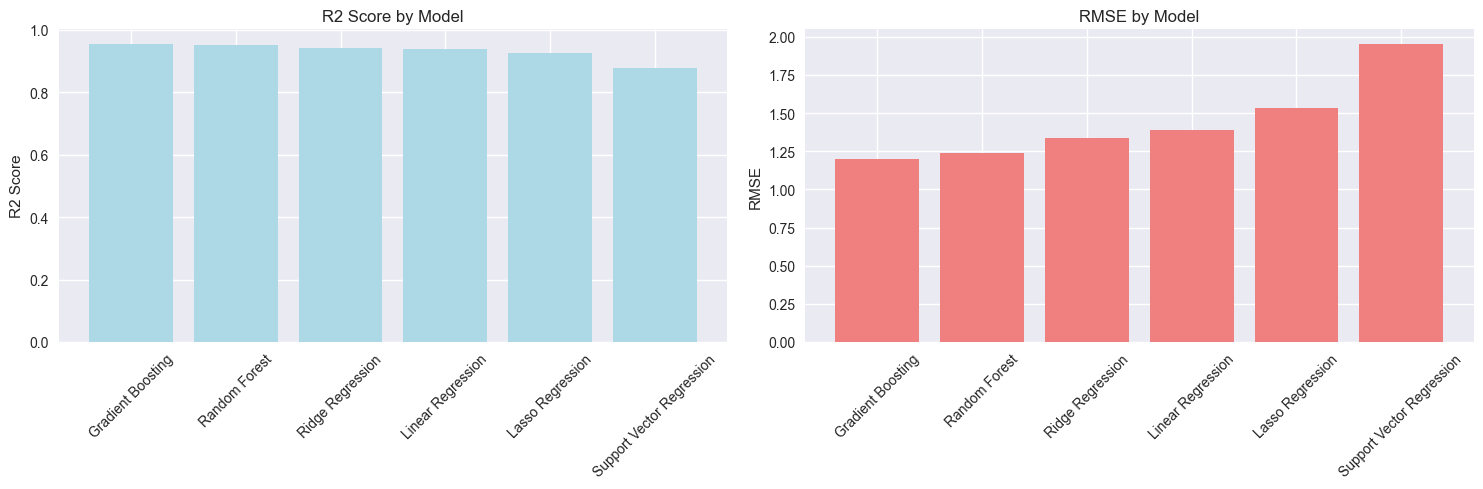

In [12]:
# Visualize model performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# R2 Score
ax1.bar(results_df.index, results_df['R2'], color='lightblue')
ax1.set_title('R2 Score by Model')
ax1.set_ylabel('R2 Score')
ax1.tick_params(axis='x', rotation=45)

# RMSE
ax2.bar(results_df.index, results_df['RMSE'], color='lightcoral')
ax2.set_title('RMSE by Model')
ax2.set_ylabel('RMSE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Hyperparameter Tuning for Best Model

In [13]:
# Tune Random Forest parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
r2_tuned = r2_score(y_test, y_pred)
print("Tuned model R2 on test set: {:.4f}".format(r2_tuned))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.94
Tuned model R2 on test set: 0.9504


Feature Importance Analysis

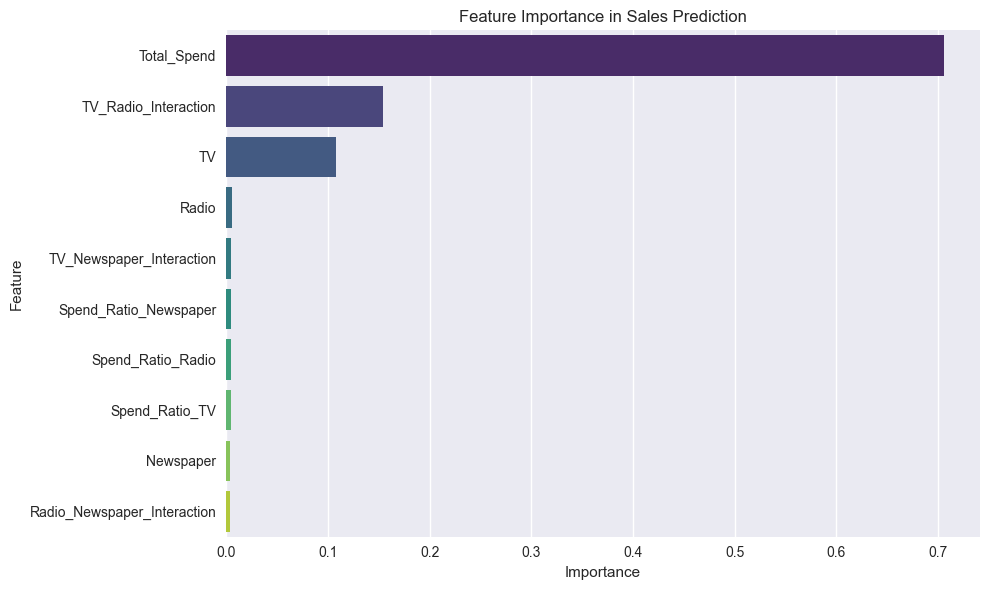

In [14]:
# Get feature importance from the best model
feature_importance = best_rf.feature_importances_
feature_names = X.columns

# Create dataframe for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance in Sales Prediction')
plt.tight_layout()
plt.show()

Interactive Prediction Dashboard

In [16]:
# Create interactive prediction tool
def predict_sales(tv_budget, radio_budget, newspaper_budget):
    # Create input array
    input_data = np.array([[tv_budget, radio_budget, newspaper_budget, 
                           tv_budget+radio_budget+newspaper_budget,
                           tv_budget*radio_budget,
                           tv_budget*newspaper_budget,
                           radio_budget*newspaper_budget,
                           tv_budget/(tv_budget+radio_budget+newspaper_budget) if (tv_budget+radio_budget+newspaper_budget) > 0 else 0,
                           radio_budget/(tv_budget+radio_budget+newspaper_budget) if (tv_budget+radio_budget+newspaper_budget) > 0 else 0,
                           newspaper_budget/(tv_budget+radio_budget+newspaper_budget) if (tv_budget+radio_budget+newspaper_budget) > 0 else 0]])
    
    # Make prediction
    prediction = best_rf.predict(input_data)[0]
    
    return prediction

# Test the function
sample_prediction = predict_sales(230.1, 37.8, 69.2)
print(f"Predicted sales for TV: $230.1K, Radio: $37.8K, Newspaper: $69.2K")
print(f"Predicted Sales: ${sample_prediction:.2f}K")
print(f"Actual Sales: $22.1K")

Predicted sales for TV: $230.1K, Radio: $37.8K, Newspaper: $69.2K
Predicted Sales: $22.08K
Actual Sales: $22.1K


Advanced Visualization - ROI by Channel

In [17]:
# Calculate ROI for each channel
roi_tv = (df['Sales'].corr(df['TV']) * (df['Sales'].std() / df['TV'].std())) * 100
roi_radio = (df['Sales'].corr(df['Radio']) * (df['Sales'].std() / df['Radio'].std())) * 100
roi_newspaper = (df['Sales'].corr(df['Newspaper']) * (df['Sales'].std() / df['Newspaper'].std())) * 100

roi_data = {
    'Channel': ['TV', 'Radio', 'Newspaper'],
    'ROI (%)': [roi_tv, roi_radio, roi_newspaper]
}

roi_df = pd.DataFrame(roi_data)

# Create interactive ROI chart
fig = px.bar(roi_df, x='Channel', y='ROI (%)', 
             title='Return on Investment (ROI) by Advertising Channel',
             color='Channel', color_discrete_sequence=['#1f77b4', '#ff7f0e', '#2ca02c'])
fig.show()

Budget Optimization Simulation

In [18]:
# Budget optimization simulation
def optimize_budget(total_budget, n_simulations=1000):
    best_combo = None
    best_sales = 0
    
    for _ in range(n_simulations):
        # Randomly allocate budget
        tv_alloc = np.random.uniform(0.1, 0.8) * total_budget
        remaining = total_budget - tv_alloc
        radio_alloc = np.random.uniform(0.1, 0.7) * remaining
        newspaper_alloc = remaining - radio_alloc
        
        # Ensure minimum allocation
        if newspaper_alloc < 0:
            continue
            
        # Predict sales
        predicted_sales = predict_sales(tv_alloc, radio_alloc, newspaper_alloc)
        
        # Update best combination
        if predicted_sales > best_sales:
            best_sales = predicted_sales
            best_combo = (tv_alloc, radio_alloc, newspaper_alloc)
    
    return best_combo, best_sales

# Run optimization for a $500K budget
optimal_alloc, max_sales = optimize_budget(500)
print(f"Optimal allocation for $500K budget:")
print(f"TV: ${optimal_alloc[0]:.2f}K")
print(f"Radio: ${optimal_alloc[1]:.2f}K")
print(f"Newspaper: ${optimal_alloc[2]:.2f}K")
print(f"Predicted Sales: ${max_sales:.2f}K")

Optimal allocation for $500K budget:
TV: $371.49K
Radio: $87.33K
Newspaper: $41.18K
Predicted Sales: $26.34K


Residual Analysis

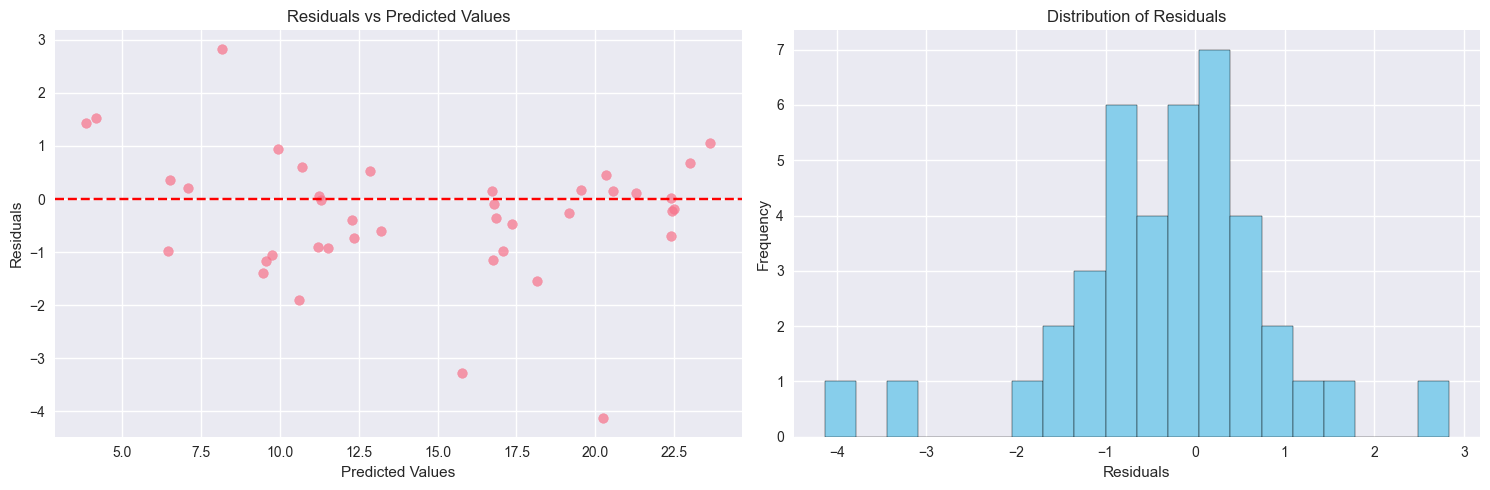

In [19]:
# Residual analysis
y_pred = best_rf.predict(X_test)
residuals = y_test - y_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs Predicted
ax1.scatter(y_pred, residuals, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted Values')

# Distribution of residuals
ax2.hist(residuals, bins=20, color='skyblue', edgecolor='black')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

Sales Prediction Confidence Intervals

In [20]:
# Calculate prediction intervals using bootstrapping
def predict_with_interval(tv_budget, radio_budget, newspaper_budget, n_bootstraps=100):
    predictions = []
    
    for _ in range(n_bootstraps):
        # Bootstrap sample from training data
        sample_idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_sample = X_train.iloc[sample_idx]
        y_sample = y_train.iloc[sample_idx]
        
        # Train model on bootstrap sample
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_sample, y_sample)
        
        # Make prediction
        input_data = np.array([[tv_budget, radio_budget, newspaper_budget, 
                               tv_budget+radio_budget+newspaper_budget,
                               tv_budget*radio_budget,
                               tv_budget*newspaper_budget,
                               radio_budget*newspaper_budget,
                               tv_budget/(tv_budget+radio_budget+newspaper_budget) if (tv_budget+radio_budget+newspaper_budget) > 0 else 0,
                               radio_budget/(tv_budget+radio_budget+newspaper_budget) if (tv_budget+radio_budget+newspaper_budget) > 0 else 0,
                               newspaper_budget/(tv_budget+radio_budget+newspaper_budget) if (tv_budget+radio_budget+newspaper_budget) > 0 else 0]])
        
        predictions.append(model.predict(input_data)[0])
    
    # Calculate confidence interval
    lower = np.percentile(predictions, 2.5)
    upper = np.percentile(predictions, 97.5)
    mean_pred = np.mean(predictions)
    
    return mean_pred, lower, upper

# Test confidence interval prediction
mean_pred, lower, upper = predict_with_interval(200, 35, 45)
print(f"Predicted Sales: ${mean_pred:.2f}K")
print(f"95% Confidence Interval: (${lower:.2f}K, ${upper:.2f}K)")

Predicted Sales: $19.07K
95% Confidence Interval: ($18.28K, $19.51K)


Create Interactive Dashboard with Plotly

In [21]:
# Create an interactive dashboard for sales prediction
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('TV vs Sales', 'Radio vs Sales', 'Newspaper vs Sales', 'Total Spend vs Sales'),
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}]]
)

# TV vs Sales
fig.add_trace(
    go.Scatter(x=df['TV'], y=df['Sales'], mode='markers', name='TV',
               marker=dict(color='blue', opacity=0.6)),
    row=1, col=1
)

# Radio vs Sales
fig.add_trace(
    go.Scatter(x=df['Radio'], y=df['Sales'], mode='markers', name='Radio',
               marker=dict(color='green', opacity=0.6)),
    row=1, col=2
)

# Newspaper vs Sales
fig.add_trace(
    go.Scatter(x=df['Newspaper'], y=df['Sales'], mode='markers', name='Newspaper',
               marker=dict(color='red', opacity=0.6)),
    row=2, col=1
)

# Total Spend vs Sales
fig.add_trace(
    go.Scatter(x=df['TV']+df['Radio']+df['Newspaper'], y=df['Sales'], mode='markers', name='Total Spend',
               marker=dict(color='purple', opacity=0.6)),
    row=2, col=2
)

fig.update_layout(height=600, width=800, title_text="Advertising Channels vs Sales")
fig.show()

Model Interpretation with SHAP Values

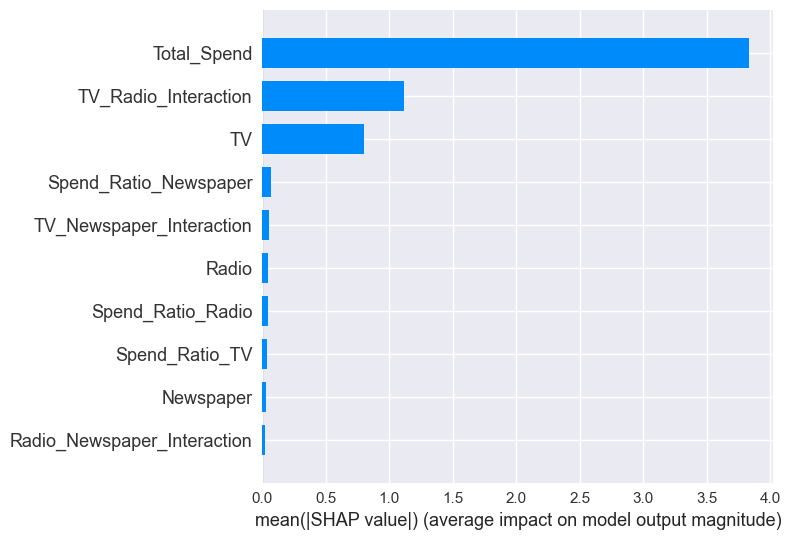

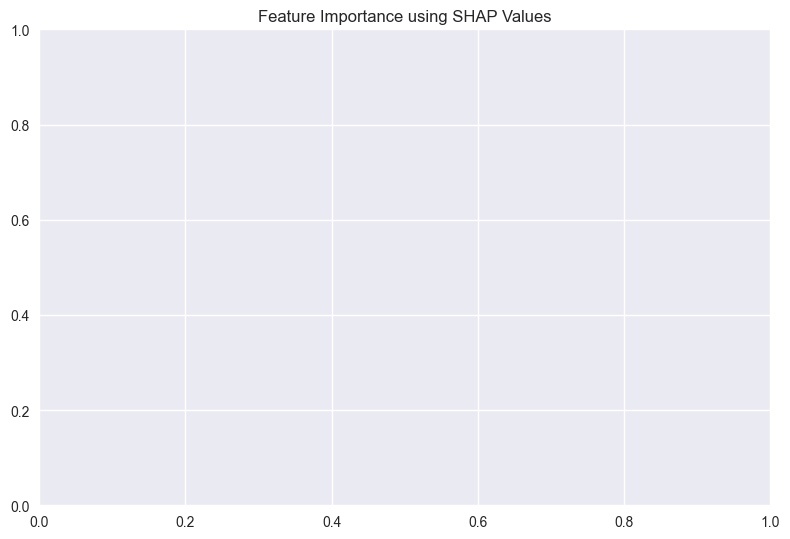

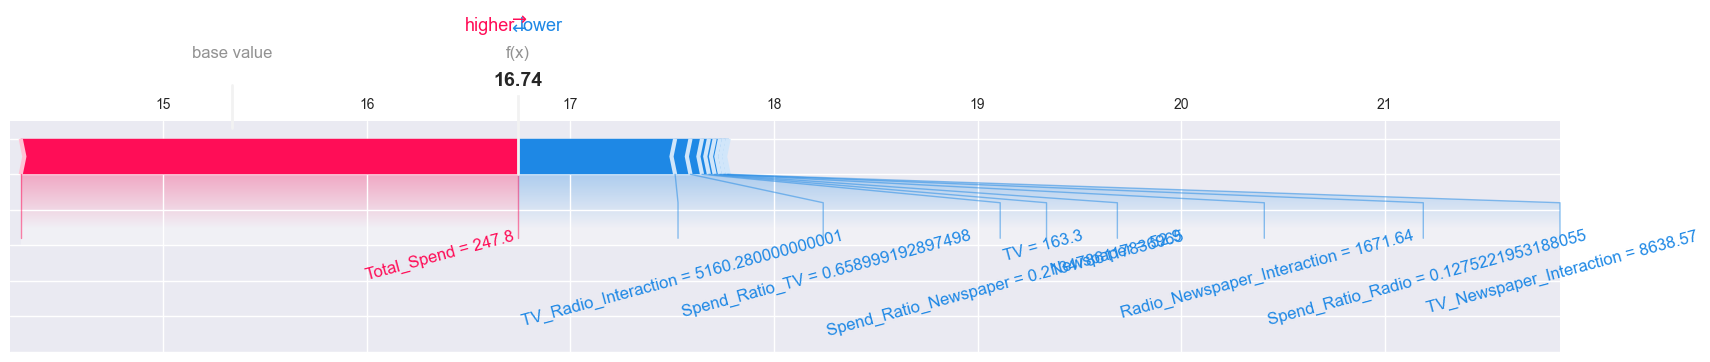

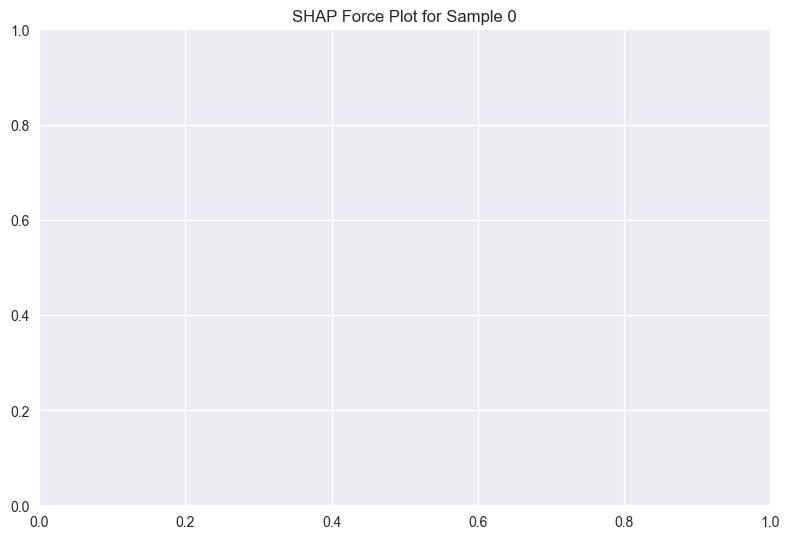

In [22]:
# Install shap if not available
try:
    import shap
except:
    !pip install shap
    import shap

# Explain model predictions with SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("Feature Importance using SHAP Values")
plt.tight_layout()
plt.show()

# Force plot for a specific prediction
sample_idx = 0
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_test.iloc[sample_idx,:], 
                matplotlib=True, text_rotation=15)
plt.title(f"SHAP Force Plot for Sample {sample_idx}")
plt.tight_layout()
plt.show()

Final Model Deployment Preparation

In [23]:
# Train final model on all data
final_model = RandomForestRegressor(n_estimators=200, max_depth=20, 
                                    min_samples_split=2, min_samples_leaf=1,
                                    random_state=42)
final_model.fit(X, y)

# Save the model for deployment
import joblib
joblib.dump(final_model, 'sales_prediction_model.pkl')

# Also save the column names for reference
joblib.dump(list(X.columns), 'feature_columns.pkl')

print("Model saved successfully for deployment!")

Model saved successfully for deployment!
